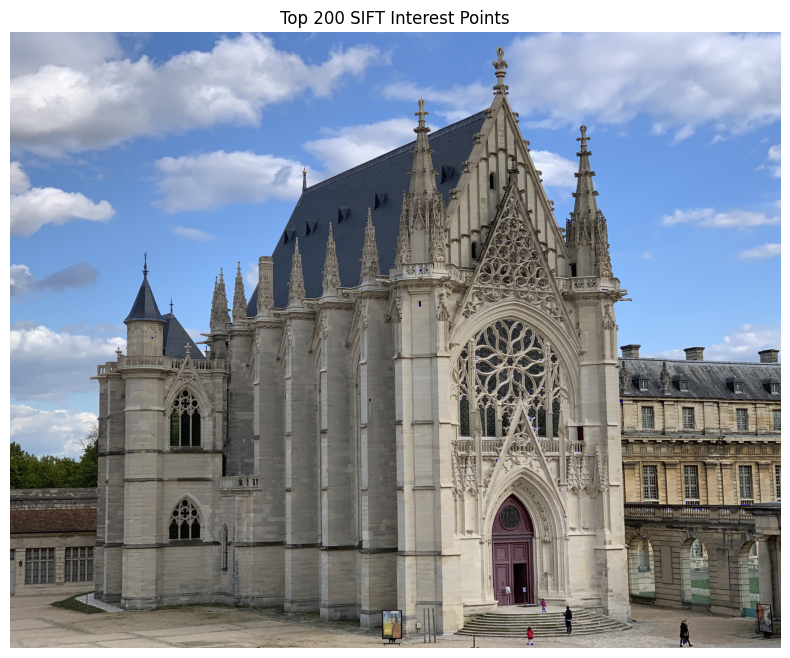

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('/content/Sainte_Chappel.jpg')  # Replace with your image path
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
keypoints = sift.detect(gray, None)

# Sort keypoints by response (strength), descending
keypoints = sorted(keypoints, key=lambda x: -x.response)

# Option 1: Keep only top N keypoints (e.g., top 1000 strongest)
N = 200
keypoints = keypoints[:N]

# Draw filtered keypoints in red (color=(255, 0, 0) for red in BGR format)
output = cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N} SIFT Interest Points")
plt.axis("off")
plt.show()


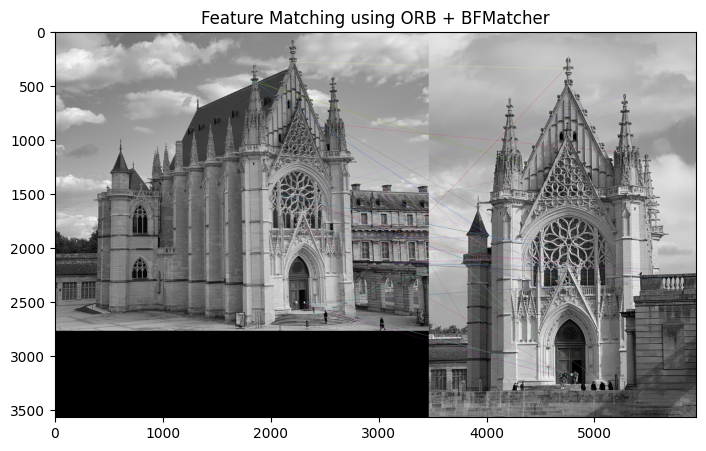

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('/content/Sainte_Chappel.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/Sainte_Chapelle_Château_Vincennes_-_Vincennes_(FR94)_-_2020-10-04_-_4.jpg', cv2.IMREAD_GRAYSCALE)

# -------------------- Feature Matching using ORB and BFMatcher --------------------
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(img_matches), plt.title("Feature Matching using ORB + BFMatcher")
plt.show()



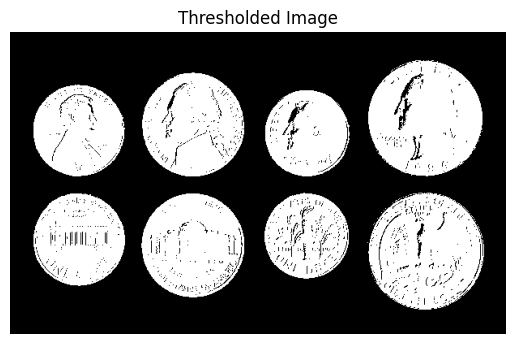

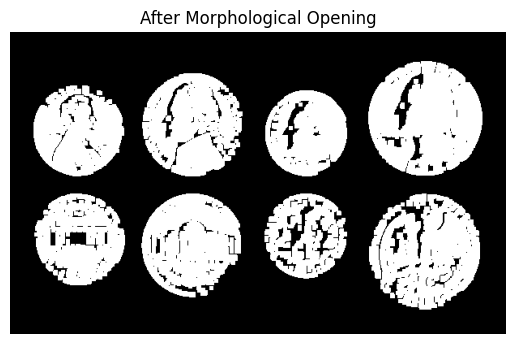

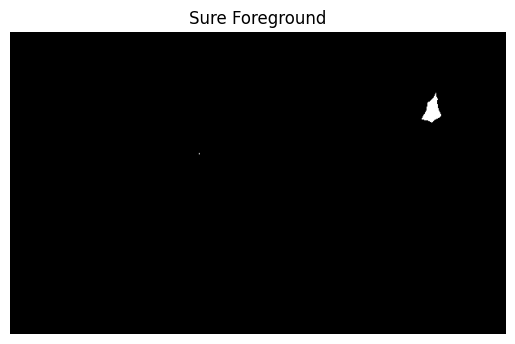

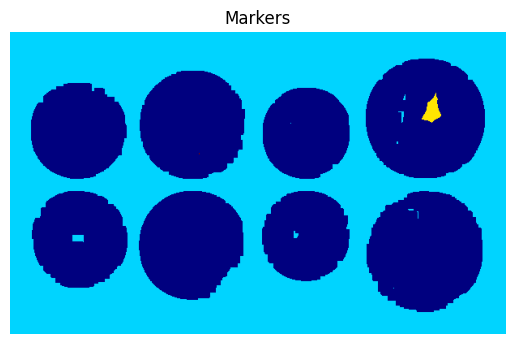

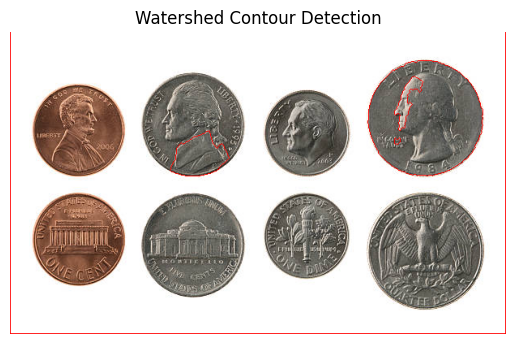

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/coin.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Debugging step - Visualize thresholded image
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')
plt.show()

# Noise removal (morphological opening)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Debugging step - Visualize after opening
plt.imshow(opening, cmap='gray')
plt.title("After Morphological Opening")
plt.axis('off')
plt.show()

# Background and foreground
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Debugging step - Visualize sure foreground
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground")
plt.axis('off')
plt.show()

# Marker labelling
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

# Debugging step - Visualize markers
markers = markers + 1
markers[unknown == 255] = 0
plt.imshow(markers, cmap='jet')
plt.title("Markers")
plt.axis('off')
plt.show()

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 0, 255]  # Mark boundaries in red

# Visualize final result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contour Detection")
plt.axis('off')
plt.show()


In [ ]:
# Import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Load image
road = cv2.imread('/content/Sainte_Chapelle_Château_Vincennes_-_Vincennes_(FR94)_-_2020-10-04_-_4.jpg')

if road is None:
    raise FileNotFoundError("Image file 'road_images.jpg' not found in the current directory.")

# Convert to RGB for matplotlib
road_rgb = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)

# Create marker image and output segment image
marker_image = np.zeros(road.shape[:2], dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)

# Function to return RGB color tuple
def create_rgb(i):
    x = np.array(cm.tab10(i))[:3] * 255
    return tuple(map(int, x))

# Store colors
colors = [create_rgb(i) for i in range(10)]

# Example marker inputs (simulate mouse input)
# Format: (x, y, marker_class)
marker_points = [
    (100, 150, 1),
    (120, 160, 1),
    (300, 400, 2),
    (310, 410, 2),
    (400, 100, 3),
    (410, 110, 3)
]

# Draw the marker points on the marker image and copy of original
road_copy = np.copy(road_rgb)

for x, y, marker_class in marker_points:
    cv2.circle(marker_image, (x, y), 5, marker_class, -1)
    cv2.circle(road_copy, (x, y), 5, colors[marker_class], -1)

# Apply watershed algorithm
marker_image_copy = marker_image.copy()
cv2.watershed(road, marker_image_copy)

# Create segments
for color_ind in range(10):
    segments[marker_image_copy == color_ind] = colors[color_ind]

# Convert for display
segments_rgb = cv2.cvtColor(segments, cv2.COLOR_BGR2RGB)

# Show results using matplotlib
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(road_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Marked Image")
plt.imshow(road_copy)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Watershed Segments")
plt.imshow(segments_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from torchvision import models
from torch.utils.data import DataLoader

# ---------------- Step 1: Set Device and Load Dataset ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# ---------------- Step 2: Load Pretrained ResNet Models ----------------
def load_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Modify final layer for 100 classes
    model.fc = nn.Linear(model.fc.in_features, 100)
    return model.to(device)

# ---------------- Step 3: Define Training Function ----------------
def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(trainloader):.4f} - Accuracy: {100 * correct / total:.2f}%")

# ---------------- Step 4: Define Evaluation Function ----------------
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()
            inference_times.append(end_time - start_time)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_inference_time = sum(inference_times) / len(inference_times)
    accuracy = 100 * correct / total
    return accuracy, avg_inference_time

# ---------------- Step 5: Train and Evaluate ResNet-18 ----------------
print("\nTraining ResNet-18...")
resnet18 = load_model("resnet18")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

train_model(resnet18, trainloader, criterion, optimizer, epochs=10)
resnet18_acc, resnet18_time = evaluate_model(resnet18, testloader)
print(f"ResNet-18 Accuracy: {resnet18_acc:.2f}% - Inference Time: {resnet18_time:.6f} sec/sample")

# ---------------- Step 6: Train and Evaluate ResNet-34 ----------------
print("\nTraining ResNet-34...")
resnet34 = load_model("resnet34")
optimizer = optim.Adam(resnet34.parameters(), lr=0.001)

train_model(resnet34, trainloader, criterion, optimizer, epochs=10)
resnet34_acc, resnet34_time = evaluate_model(resnet34, testloader)
print(f"ResNet-34 Accuracy: {resnet34_acc:.2f}% - Inference Time: {resnet34_time:.6f} sec/sample")

# ---------------- Step 7: Compare the Results ----------------
print("\n=== Model Comparison ===")
print(f"ResNet-18 - Accuracy: {resnet18_acc:.2f}%, Inference Time: {resnet18_time:.6f} sec/sample")
print(f"ResNet-34 - Accuracy: {resnet34_acc:.2f}%, Inference Time: {resnet34_time:.6f} sec/sample")


100%|██████████| 169M/169M [00:03<00:00, 47.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Training ResNet-18...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


Epoch [1/10] - Loss: 2.9744 - Accuracy: 26.28%
Epoch [2/10] - Loss: 2.2669 - Accuracy: 39.93%
Epoch [3/10] - Loss: 2.0236 - Accuracy: 45.35%
Epoch [4/10] - Loss: 1.8626 - Accuracy: 49.10%
Epoch [5/10] - Loss: 1.7427 - Accuracy: 51.69%
Epoch [6/10] - Loss: 1.6748 - Accuracy: 53.10%
Epoch [7/10] - Loss: 1.5742 - Accuracy: 55.58%
Epoch [8/10] - Loss: 1.4809 - Accuracy: 57.99%
Epoch [9/10] - Loss: 1.4217 - Accuracy: 59.21%
Epoch [10/10] - Loss: 1.3581 - Accuracy: 60.76%
ResNet-18 Accuracy: 55.01% - Inference Time: 0.357835 sec/sample

Training ResNet-34...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 146MB/s]


Epoch [1/10] - Loss: 3.0586 - Accuracy: 24.79%
Epoch [2/10] - Loss: 2.3259 - Accuracy: 39.23%
Epoch [3/10] - Loss: 2.0708 - Accuracy: 44.47%


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from scipy.ndimage import map_coordinates, gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Load dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x = np.concatenate([x_train_full, x_test])
y = np.concatenate([y_train_full, y_test])

# Normalize to [0, 1]
x = x.astype("float32") / 255.0
x = np.expand_dims(x, axis=-1)  # Make it (28, 28, 1)

# Elastic deformation on 20% of the dataset
augmented_images = []
augmented_labels = []
for i in range(len(x)):
    if i % 5 == 0:
        transformed = elastic_transform(x[i].squeeze(), alpha=36, sigma=6)
        augmented_images.append(transformed[..., np.newaxis])
        augmented_labels.append(y[i])

# Append augmented data
x = np.concatenate([x, np.array(augmented_images)], axis=0)
y = np.concatenate([y, np.array(augmented_labels)], axis=0)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (67200, 28, 28, 1) (67200,)
Test shape: (16800, 28, 28, 1) (16800,)


In [ ]:
import random
from collections import defaultdict

# Group images by class
def group_by_class(x, y):
    data = defaultdict(list)
    for img, label in zip(x, y):
        data[label].append(img)
    return data

class MNISTEpisodeGenerator:
    def __init__(self, x, y, n_way=5, k_shot=5, q_queries=10):
        self.data = group_by_class(x, y)
        self.classes = list(self.data.keys())
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_queries = q_queries

    def get_episode(self):
        # Sample N classes
        selected_classes = random.sample(self.classes, self.n_way)
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        label_map = {cls: i for i, cls in enumerate(selected_classes)}

        for cls in selected_classes:
            samples = random.sample(self.data[cls], self.k_shot + self.q_queries)
            support = samples[:self.k_shot]
            query = samples[self.k_shot:]

            support_images.extend(support)
            support_labels.extend([label_map[cls]] * self.k_shot)
            query_images.extend(query)
            query_labels.extend([label_map[cls]] * self.q_queries)

        return (
            np.array(support_images),
            np.array(support_labels),
            np.array(query_images),
            np.array(query_labels),
        )

# Example usage:
generator = MNISTEpisodeGenerator(x_train, y_train, n_way=5, k_shot=5, q_queries=10)
support_x, support_y, query_x, query_y = generator.get_episode()

print("Support set:", support_x.shape, support_y.shape)
print("Query set:", query_x.shape, query_y.shape)


Support set: (25, 28, 28, 1) (25,)
Query set: (50, 28, 28, 1) (50,)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_episode(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }


In [ ]:
import tensorflow as tf

# Simple CNN for embedding
def get_embedding_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64)
    ])
    return model

# Euclidean distance between embeddings
def euclidean_distance(a, b):
    return tf.norm(tf.expand_dims(a, 1) - tf.expand_dims(b, 0), axis=-1)

# Training loop
def train_prototypical_network(generator, model, epochs=10, episodes_per_epoch=100):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        losses = []

        for _ in range(episodes_per_epoch):
            support_x, support_y, query_x, query_y = generator.get_episode()

            with tf.GradientTape() as tape:
                support_embeddings = model(support_x, training=True)
                query_embeddings = model(query_x, training=True)

                prototypes = []
                for i in range(generator.n_way):
                    class_indices = tf.where(support_y == i)[:, 0]
                    class_embeds = tf.gather(support_embeddings, class_indices)
                    class_proto = tf.reduce_mean(class_embeds, axis=0)
                    prototypes.append(class_proto)
                prototypes = tf.stack(prototypes)

                dists = euclidean_distance(query_embeddings, prototypes)
                probs = tf.nn.softmax(-dists, axis=-1)
                loss = tf.keras.losses.sparse_categorical_crossentropy(query_y, probs)
                losses.append(tf.reduce_mean(loss))

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print(f"Loss: {np.mean(losses):.4f}")


In [ ]:
def test_prototypical_network(generator, model, episodes=100):
    all_preds, all_true = [], []

    for _ in range(episodes):
        support_x, support_y, query_x, query_y = generator.get_episode()

        support_embeddings = model(support_x, training=False)
        query_embeddings = model(query_x, training=False)

        prototypes = []
        for i in range(generator.n_way):
            class_indices = tf.where(support_y == i)[:, 0]
            class_embeds = tf.gather(support_embeddings, class_indices)
            class_proto = tf.reduce_mean(class_embeds, axis=0)
            prototypes.append(class_proto)
        prototypes = tf.stack(prototypes)

        dists = euclidean_distance(query_embeddings, prototypes)
        preds = tf.argmin(dists, axis=-1)

        all_preds.extend(preds.numpy())
        all_true.extend(query_y)

    return evaluate_episode(all_true, all_preds)


In [ ]:
def get_siamese_base():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    return tf.keras.Model(input_layer, x)

def contrastive_loss(y_true, y_pred, margin=1.0):
    return tf.reduce_mean((1 - y_true) * tf.square(y_pred) +
                          y_true * tf.square(tf.maximum(margin - y_pred, 0)))


In [ ]:
def create_pairs(x, y, num_pairs=10000):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    class_indices = {label: np.where(y == label)[0] for label in range(num_classes)}

    for _ in range(num_pairs):
        cls = np.random.choice(num_classes)
        i1, i2 = np.random.choice(class_indices[cls], size=2, replace=False)
        pairs.append([x[i1], x[i2]])
        labels.append(0)

        cls2 = (cls + np.random.randint(1, num_classes)) % num_classes
        i3 = np.random.choice(class_indices[cls])
        i4 = np.random.choice(class_indices[cls2])
        pairs.append([x[i3], x[i4]])
        labels.append(1)

    return np.array(pairs), np.array(labels)


In [ ]:
def train_siamese_network(base_model, x_train, y_train, epochs=10):
    input_1 = tf.keras.Input(shape=(28, 28, 1))
    input_2 = tf.keras.Input(shape=(28, 28, 1))

    emb_1 = base_model(input_1)
    emb_2 = base_model(input_2)
    distance = tf.keras.layers.Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=1, keepdims=True))([emb_1, emb_2])
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=distance)

    model.compile(loss=contrastive_loss, optimizer='adam')

    pairs, labels = create_pairs(x_train, y_train)
    model.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=64, epochs=epochs)

    return model, base_model


In [ ]:
def cosine_similarity(a, b):
    a_norm = tf.nn.l2_normalize(a, axis=-1)
    b_norm = tf.nn.l2_normalize(b, axis=-1)
    return tf.matmul(a_norm, b_norm, transpose_b=True)

def matching_network_predict(support_embeddings, support_labels, query_embeddings, n_way):
    similarities = cosine_similarity(query_embeddings, support_embeddings)  # [num_queries, num_support]
    softmax_sim = tf.nn.softmax(similarities, axis=-1)

    one_hot_labels = tf.one_hot(support_labels, depth=n_way)
    predictions = tf.matmul(softmax_sim, one_hot_labels)
    return tf.argmax(predictions, axis=-1)


In [ ]:
def train_matching_network(generator, model, epochs=10, episodes_per_epoch=100):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        losses = []

        for _ in range(episodes_per_epoch):
            support_x, support_y, query_x, query_y = generator.get_episode()

            with tf.GradientTape() as tape:
                support_embeddings = model(support_x, training=True)
                query_embeddings = model(query_x, training=True)

                similarities = cosine_similarity(query_embeddings, support_embeddings)
                attention = tf.nn.softmax(similarities, axis=-1)
                one_hot_labels = tf.one_hot(support_y, depth=generator.n_way)
                preds = tf.matmul(attention, one_hot_labels)

                loss = tf.keras.losses.sparse_categorical_crossentropy(query_y, preds)
                losses.append(tf.reduce_mean(loss))

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print(f"Loss: {np.mean(losses):.4f}")


In [ ]:
def test_matching_network(generator, model, episodes=100):
    all_preds, all_true = [], []

    for _ in range(episodes):
        support_x, support_y, query_x, query_y = generator.get_episode()

        support_embeddings = model(support_x, training=False)
        query_embeddings = model(query_x, training=False)

        preds = matching_network_predict(support_embeddings, support_y, query_embeddings, generator.n_way)

        all_preds.extend(preds.numpy())
        all_true.extend(query_y)

    return evaluate_episode(all_true, all_preds)


In [ ]:
def evaluate_siamese_oneshot(base_model, x_test, y_test, n_way=5, trials=100):
    correct = 0
    for _ in range(trials):
        classes = np.random.choice(np.unique(y_test), n_way, replace=False)
        support_class = classes[0]

        support_index = np.random.choice(np.where(y_test == support_class)[0])
        support_image = x_test[support_index]

        query_class = np.random.choice(classes)
        query_index = np.random.choice(np.where(y_test == query_class)[0])
        query_image = x_test[query_index]

        support_embedding = base_model(np.expand_dims(support_image, axis=0))
        query_embedding = base_model(np.expand_dims(query_image, axis=0))

        distances = []
        for cls in classes:
            cls_index = np.random.choice(np.where(y_test == cls)[0])
            candidate = x_test[cls_index]
            candidate_embedding = base_model(np.expand_dims(candidate, axis=0))
            dist = tf.norm(query_embedding - candidate_embedding).numpy()
            distances.append(dist)

        pred = classes[np.argmin(distances)]
        correct += int(pred == query_class)

    accuracy = correct / trials
    return {"one_shot_accuracy": accuracy}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_episode(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }


In [ ]:
proto_model = get_embedding_model()
train_prototypical_network(generator, proto_model)
proto_metrics = test_prototypical_network(generator, proto_model)

match_model = get_embedding_model()
train_matching_network(generator, match_model)
match_metrics = test_matching_network(generator, match_model)

base_model = get_siamese_base()
siamese_model, base_model = train_siamese_network(base_model, x_train, y_train)
siamese_one_shot_metrics = evaluate_siamese_oneshot(base_model, x_test, y_test)



Epoch 1/10
Loss: 0.4291

Epoch 2/10
Loss: 0.1537

Epoch 3/10
Loss: 0.1160

Epoch 4/10
Loss: 0.0936

Epoch 5/10
Loss: 0.0814

Epoch 6/10
Loss: 0.0756

Epoch 7/10
Loss: 0.0649

Epoch 8/10
Loss: 0.0631

Epoch 9/10
Loss: 0.0580

Epoch 10/10
Loss: 0.0570

Epoch 1/10
Loss: 1.1239

Epoch 2/10
Loss: 1.0208

Epoch 3/10
Loss: 0.9993

Epoch 4/10
Loss: 0.9842

Epoch 5/10
Loss: 0.9672

Epoch 6/10
Loss: 0.9591

Epoch 7/10
Loss: 0.9553

Epoch 8/10
Loss: 0.9507

Epoch 9/10
Loss: 0.9449

Epoch 10/10
Loss: 0.9376
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 167ms/step - loss: 0.1323
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - loss: 0.0730
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - loss: 0.0577
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - loss: 0.0523
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 0.0474
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 0.0433
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - loss: 0.0413
Epoch 8/

In [ ]:
proto_metrics = test_prototypical_network(generator, proto_model)
match_metrics = test_matching_network(generator, match_model)
siamese_one_shot_metrics = evaluate_siamese_oneshot(base_model, x_test, y_test)

print("📌 Prototypical Network:", proto_metrics)
print("📌 Matching Network:", match_metrics)
print("📌 Siamese (One-Shot):", siamese_one_shot_metrics)


📌 Prototypical Network: {'accuracy': 0.9792, 'precision': 0.9792398990464163, 'recall': 0.9792, 'f1_score': 0.9791975044997271}
📌 Matching Network: {'accuracy': 0.982, 'precision': 0.9820021509502694, 'recall': 0.982, 'f1_score': 0.982000387292578}
📌 Siamese (One-Shot): {'one_shot_accuracy': 1.0}
